In [48]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!curl -Lo data.zip https://www.kaggle.com/api/v1/datasets/download/jeanmidev/smart-meters-in-london
!mkdir data
!unzip data.zip -d data
!rm data.zip

In [ ]:
households = pd.read_csv("data/informations_households.csv")
acorn = pd.read_csv(
    filepath_or_buffer="data/acorn_details.csv",
    encoding="windows-1252",
)
holidays = pd.read_csv(
    filepath_or_buffer="data/uk_bank_holidays.csv",
    parse_dates=["Bank holidays"],
)
daily_weather = pd.read_csv(
    filepath_or_buffer="data/weather_daily_darksky.csv",
    parse_dates=[
        "temperatureMaxTime",
        "temperatureMinTime",
        "apparentTemperatureMinTime",
        "apparentTemperatureHighTime",
        "time",
        "sunsetTime",
        "sunriseTime",
        "temperatureHighTime",
        "uvIndexTime",
        "temperatureLowTime",
        "apparentTemperatureMaxTime",
        "apparentTemperatureLowTime",
    ],
)
hourly_weather = pd.read_csv(
    filepath_or_buffer="data/weather_hourly_darksky.csv",
    parse_dates=["time"],
)

In [2]:
daily_consumption = pd.concat(
    pd.read_csv(filepath_or_buffer=path, parse_dates=["day"])
    for path in glob.glob("data/daily_dataset/daily_dataset/block_*.csv")
)
half_hourly_consumption_long = pd.concat(
    pd.read_csv(
        filepath_or_buffer=path,
        converters={
            "energy(kWh/hh)": lambda x: pd.to_numeric(arg=x.strip(), errors="coerce"),
        },
        parse_dates=["tstp"],
    )
    for path in glob.glob("data/halfhourly_dataset/halfhourly_dataset/block_*.csv")
)
half_hourly_consumption_wide = pd.concat(
    pd.read_csv(filepath_or_buffer=path, parse_dates=["day"])
    for path in glob.glob("data/hhblock_dataset/hhblock_dataset/block_*.csv")
)

## Month vs. avg. monthly consumption

In [130]:
t = daily_consumption.copy()
t["year"] = t["day"].dt.year
t["month"] = t["day"].dt.month
t = t.groupby(["LCLid", "year", "month"])["energy_sum"].sum().reset_index()
t = t.groupby("month")["energy_sum"].mean()
t = t.rename("Avg. monthly consumption (kWh)")
t.index.name = "Month"
t

Month
1     371.289164
2     324.102117
3     357.854958
4     282.515420
5     252.123494
6     245.403152
7     248.575938
8     246.498210
9     258.064297
10    298.194840
11    334.795762
12    368.063662
Name: Avg. monthly consumption (kWh), dtype: float64

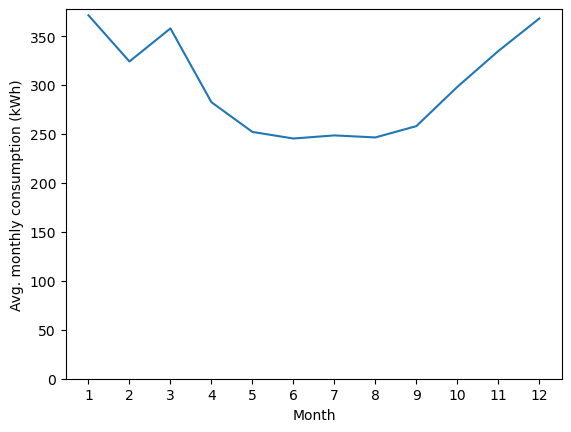

In [132]:
plt.plot(t.index, t.values)
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylim(bottom=0)
plt.ylabel("Avg. monthly consumption (kWh)");